In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
import copy
from dnc import DNC
sns.set()

In [2]:
df = pd.read_csv('GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [4]:
num_writes = 1
num_reads = 4
memory_size = 16
word_size = 16
clip_value = 20
max_grad_norm = 5
learning_rate = 1e-4
optimizer_epsilon = 1e-10
batch_size = 32

size_layer = 128
embedded_size = 128
timestamp = 5
epoch = 500
future_day = 50

access_config = {
    "memory_size": memory_size,
    "word_size": word_size,
    "num_reads": num_reads,
    "num_writes": num_writes,
}
controller_config = {
    "hidden_size": size_layer,
}

In [5]:
class Model:
    def __init__(self, learning_rate, size, size_layer, output_size):
        
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.cells = DNC(access_config=access_config, controller_config=controller_config,
                       output_size=size_layer, clip_value=clip_value)
        self.initial_state = self.cells.initial_state(1)
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.cells, self.X, 
                                                          initial_state = self.initial_state, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [6]:
tf.reset_default_graph()
modelnn = Model(0.01, df_log.shape[1], size_layer, df_log.shape[1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    total_loss = 0
    modelnn.initial_state = modelnn.cells.initial_state(1)
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        _, loss,last_state = sess.run([modelnn.optimizer, modelnn.cost, modelnn.last_state], feed_dict={modelnn.X: batch_x, 
                                                                                             modelnn.Y: batch_y})
        modelnn.initial_state = last_state
        total_loss += loss
    total_loss /= (df_log.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 100 avg loss: 0.0073977784719318155
epoch: 200 avg loss: 0.005268539491808042
epoch: 300 avg loss: 0.0030734442797256635
epoch: 400 avg loss: 0.0036360668239649387
epoch: 500 avg loss: 0.0037853180209640415


In [8]:
modelnn.initial_state = modelnn.cells.initial_state(1)
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits,last_state = sess.run([modelnn.logits,modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0)})
    output_predict[k + 1: k + timestamp + 1, :] = out_logits
    modelnn.initial_state = last_state
    
out_logits,last_state = sess.run([modelnn.logits,modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[upper_b: , :], axis = 0)})
modelnn.initial_state = last_state
output_predict[upper_b + 1: df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1]+timedelta(days=1))

In [9]:
for i in range(future_day - 1):
    out_logits,last_state = sess.run([modelnn.logits,modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0)})
    modelnn.initial_state = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1]+timedelta(days=1))

In [10]:
df_log = minmax.inverse_transform(output_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

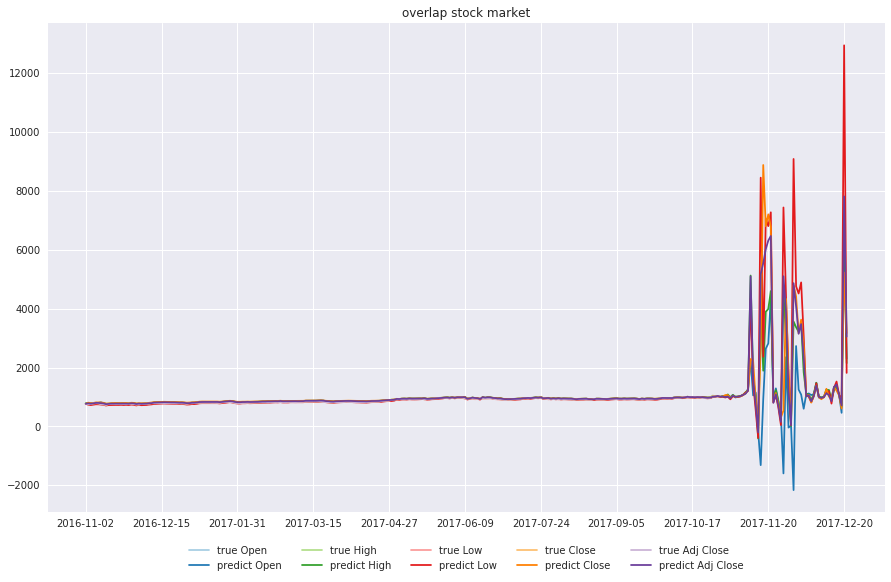

In [11]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(x_range_original, df.iloc[:, 1], label = 'true Open', color = current_palette[0])
ax.plot(x_range_future, df_log[:, 0], label = 'predict Open', color = current_palette[1])
ax.plot(x_range_original, df.iloc[:, 2], label = 'true High', color = current_palette[2])
ax.plot(x_range_future, df_log[:, 1], label = 'predict High', color = current_palette[3])
ax.plot(x_range_original, df.iloc[:, 3], label = 'true Low', color = current_palette[4])
ax.plot(x_range_future, df_log[:, 2], label = 'predict Low', color = current_palette[5])
ax.plot(x_range_original, df.iloc[:, 4], label = 'true Close', color = current_palette[6])
ax.plot(x_range_future, df_log[:, 3], label = 'predict Close', color = current_palette[7])
ax.plot(x_range_original, df.iloc[:, 5], label = 'true Adj Close', color = current_palette[8])
ax.plot(x_range_future, df_log[:, 4], label = 'predict Adj Close', color = current_palette[9])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()